In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

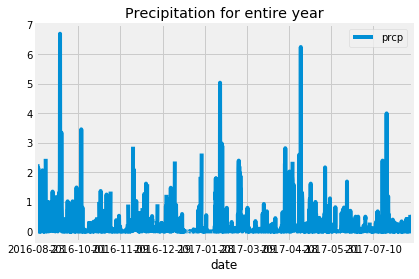

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# With latest date in our database we can compile data for the entire previous 12 months
Latest_Maximum_Date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

# extract string from query object
Latest_Maximum_Date = Latest_Maximum_Date[0]

#convert date string to datetime object
Latest_Maximum_Date = dt.datetime.strptime(Latest_Maximum_Date, '%Y-%m-%d')
latestYear = int(dt.datetime.strftime(Latest_Maximum_Date, '%Y'))
latestMonth = int(dt.datetime.strftime(Latest_Maximum_Date, '%m'))
latestDay = int(dt.datetime.strftime(Latest_Maximum_Date, '%d'))

# Calculate the date 1 year ago from the last data point in the database
date_1_year_ago = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_1_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_fall_data_df = pd.DataFrame(data_prcp)
rain_fall_data = rain_fall_data_df.set_index('date')

# Sort the dataframe by date
rain_fall_data = rain_fall_data.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_fall_data.plot(title="Precipitation for entire year")
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_fall_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
weather_station = session.query(Station).count()
print("Station Count: " + str(weather_station))

Station Count: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"These are the most active stations in Hawaii")
active_stations

These are the most active stations in Hawaii


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded
stationID = active_stations[0][0]
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded at the most active station is {lowestTemp} degrees Farenheit.")

The lowest temperature recorded at the most active station is 54.0 degrees Farenheit.


In [15]:
# Using the station id from the previous query, calculate highest temperature recorded
highestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.desc())
                     .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded at the most active station is {highestTemp} degrees Farenheit.")

The highest temperature recorded at the most active station is 85.0 degrees Farenheit.


In [17]:
# Using the station id from the previous query, calculate the average temperature of the most active station?
temparature_average = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
temparature_average= '{0:.3}'.format(temparature_average[0][0])
print(f"The average temperature recorded at the most active station is {temparature_average} degrees Farenheit.")

The average temperature recorded at the most active station is 71.7 degrees Farenheit.


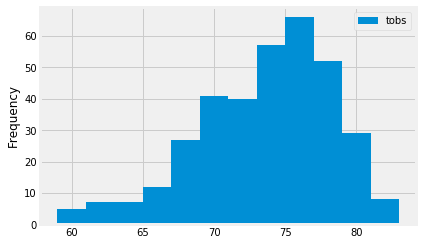

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
higher_tobs = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > date_1_year_ago)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())
#cetup DataFrame
higher_tobs_df = pd.DataFrame(higher_tobs)
higher_tobs_df = higher_tobs_df.set_index('date')

#Sort DataFrame by date in ascending order
tobs_histogram = higher_tobs_df.sort_index(ascending=True)

#hPlot tobs histogram with pandas
tobs_histogram.plot(kind='hist', bins=12)
plt.savefig("Images/tobs_histogram.png")

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin_tavg_tmax = calc_temps('2017-06-14','2017-06-30')
tmin_tavg_tmax

[(71.0, 77.03703703703704, 82.0)]

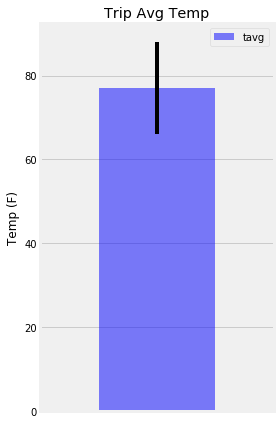

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Create a dataframe with the calculated tmin, tavg, and tmax values
tmin_tavg_tmax_df = pd.DataFrame(tmin_tavg_tmax, columns=['tmin', 'tavg', 'tmax'])


# Plot the results from your previous query as a bar chart. 
tmin_tavg_tmax_df.plot.bar(y='tavg', yerr=(tmin_tavg_tmax_df['tmax'] - tmin_tavg_tmax_df['tmin']), title='Trip Avg Temp', color='blue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()


In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_parms = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

Start_of_trip = '2017-06-14'
End_of_trip = '2017-06-30'
Weather_Stations_Rain = (session.query(*trip_parms)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= Start_of_trip)
                   .filter(Measurement.date <= End_of_trip)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
Weather_Stations_Rain_df = pd.DataFrame(np.array(Weather_Stations_Rain))

#rename columns
Weather_Stations_Rain_df = Weather_Stations_Rain_df.rename(columns={0: "Station Code", 1: "Station Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

Weather_Stations_Rain_df


,Station Code,Station Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",6.289999999999999,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",2.05,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",1.4600000000000004,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.0899999999999999,21.5213,-157.8374,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.21000000000000002,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.19,21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",0.12,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


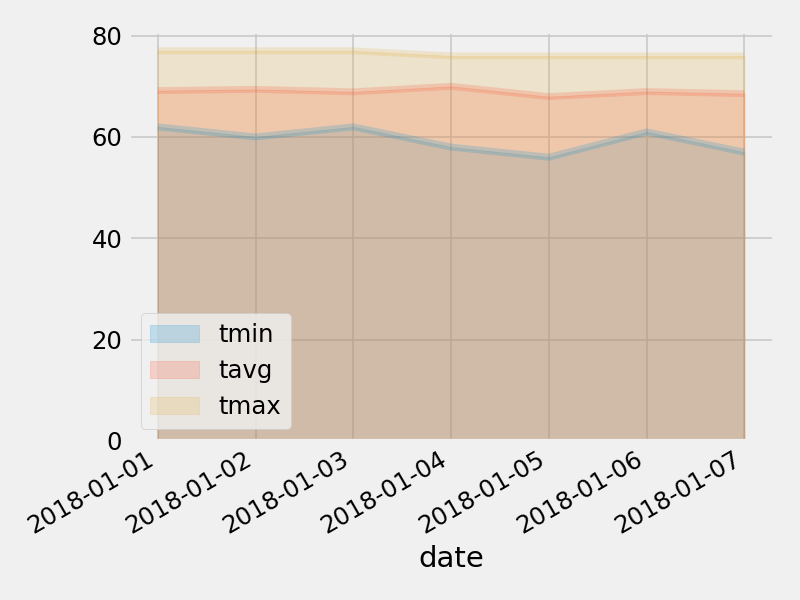

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
